In [0]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
import requests
import os
from collections import Counter

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

from tensorflow.keras import models, layers, optimizers, utils, datasets, preprocessing, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import resnet, vgg16, inception_v3
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.utils import to_categorical

tf.random.set_seed(17)

TensorFlow 2.x selected.


Using TensorFlow backend.


In [3]:
!rm -rf cousteau
!git clone https://github.com/datawookie/cousteau.git
  
from cousteau.keras.plot import plot_history

Cloning into 'cousteau'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 18 (delta 6), reused 16 (delta 4), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [4]:
!rm -rf car-dataset # allows us to re-clone the dataset w/ updates and get the changes - if folder exists, clone does not work and we won't get anychanges
!git clone https://github.com/GerardWalsh/car-dataset.git

Cloning into 'car-dataset'...
remote: Enumerating objects: 600, done.
remote: Counting objects: 100% (600/600), done.
remote: Compressing objects: 100% (537/537), done.
remote: Total 600 (delta 99), reused 558 (delta 62), pack-reused 0
Receiving objects: 100% (600/600), 27.92 MiB | 9.88 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [0]:
image_paths = list(paths.list_images("car-dataset/train"))

images = []
labels = []

for path in image_paths:
  img = preprocessing.image.load_img(path, target_size=(224, 224))
  img = np.expand_dims(img, axis=0)
  
  images.append(img)

  label = path.split(os.path.sep)[-2]
  if label == "7_5":
    label = 0
  elif label == "7":
    label = 1
  elif label == '6':
    label = 2
  else: 
    label = 3
  labels.append(label)

In [6]:
Counter(labels).keys()

dict_keys([2, 1, 3, 0])

In [7]:
Counter(labels).values()

dict_values([89, 92, 60, 80])

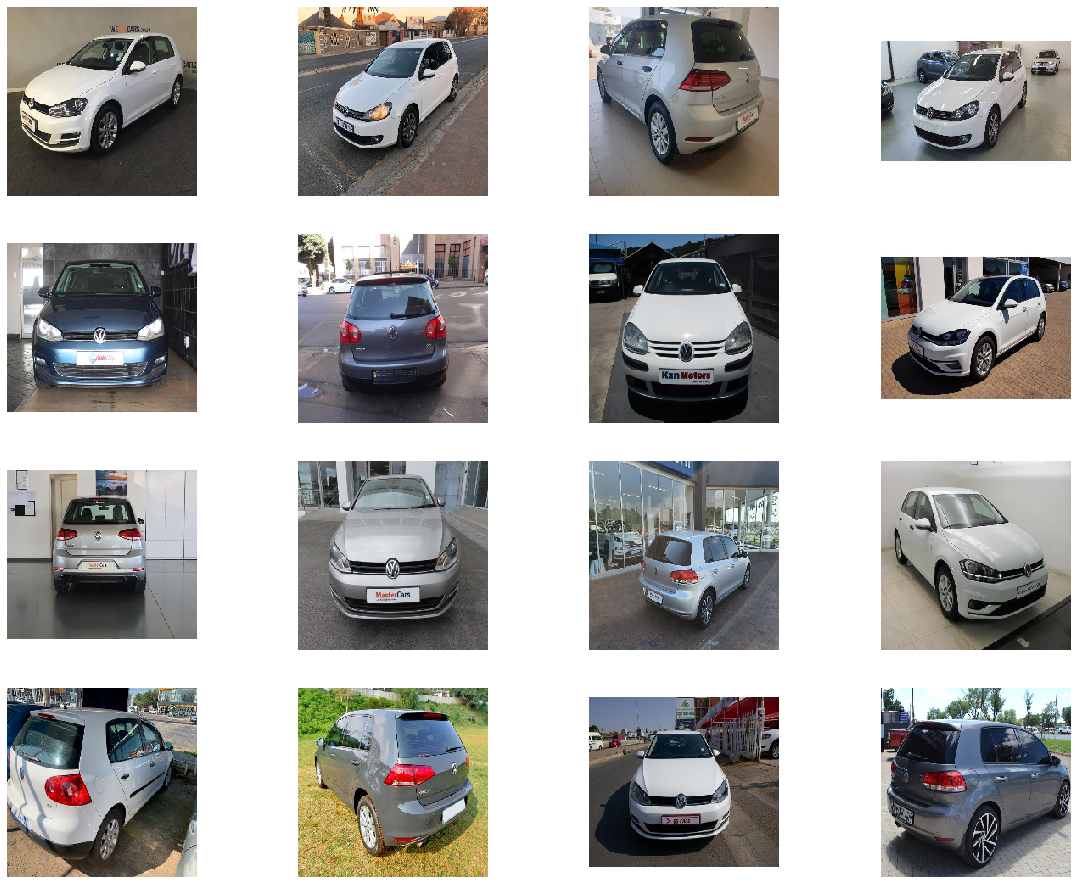

In [8]:
fig = plt.figure(figsize = (20, 16))

for i, img in zip(range(16), random.sample(images, 16)):
  fig.add_subplot(4, 4, i+1)
  plt.axis('off')
  plt.imshow(np.squeeze(img))

plt.show()

In [0]:
datagen = preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [0]:
def augment_image(image, replicates=4):
    images = [image]
    i = 1
    for batch in datagen.flow(image, batch_size=1):
        images.append(batch)
        i += 1
        if i >= replicates:
            break
    return images

In [0]:
REPLICATES = 4

In [0]:
images = [augment_image(image, REPLICATES) for image in images]

In [0]:
images = [image for sublist in images for image in sublist]

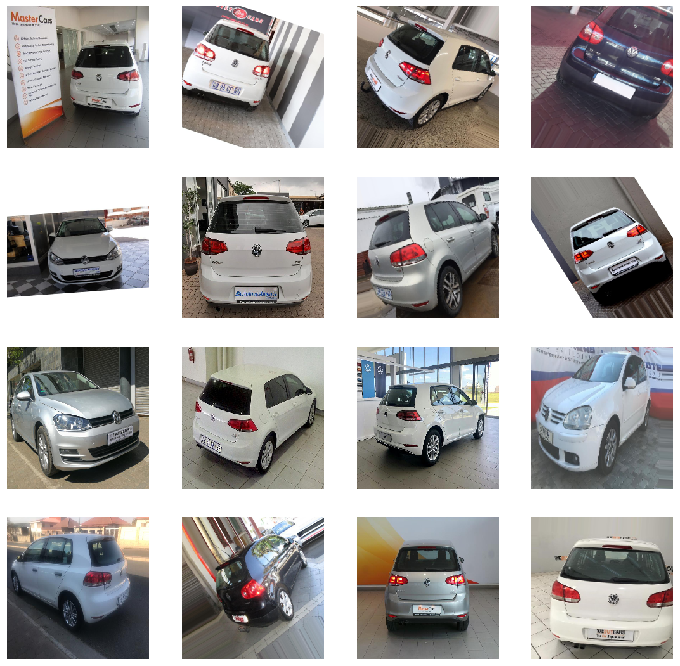

In [14]:
fig = plt.figure(figsize = (12, 12))

for i, img in zip(range(16), random.sample(images, 16)):
  fig.add_subplot(4, 4, i+1)
  plt.axis('off')
  # Transformations result in float32, so cast to uint8.
  plt.imshow(np.squeeze(img).astype('uint8'))

plt.show()

In [0]:
labez = [[label] * REPLICATES for label in labels]

In [0]:
labelz = np.array([label for sublist in labez for label in sublist])

In [17]:
print('Image count (after transform): {}'.format(len(images)), '\n', 'Label count (after transform): {}'.format(len(labelz)))

Image count (after transform): 1284 
 Label count (after transform): 1284


In [0]:
images = np.concatenate(images)

In [0]:
input_shape = images.shape[1:]

In [0]:
images = resnet.preprocess_input(images)

In [0]:
(X_train, X_test, y_train, y_test) = train_test_split(images, labelz, test_size=0.2, random_state=13)

In [0]:
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# VGG w/ weights initialised from Imagenet

In [0]:
BATCH_SIZE=32
EPOCHS = 30
LEARNING_RATE = 5e-5

In [24]:
base_model_hold = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model = base_model_hold
base_model.trainable = True

58892288/58889256 [==============================] - 5s 0us/step


In [25]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
def build_network(base, dropout_perc = 0.5, kernel_reg = 0.05):

  model = models.Sequential()

  model.add(base)
  model.add(layers.Flatten())
  model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(kernel_reg)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(dropout_perc))
  model.add(layers.Dense(4, activation='softmax'))

  return model

In [0]:
vgg = build_network(base_model)

In [0]:
vgg.compile(
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=optimizers.Adam(lr=LEARNING_RATE),
    metrics=['accuracy']
)

In [29]:
history = vgg.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_split=0.2
)

Train on 821 samples, validate on 206 samples
Epoch 1/30
821/821 [==============================] - 18s 21ms/sample - loss: 3.4357 - accuracy: 0.3471 - val_loss: 4.2614 - val_accuracy: 0.4660
Epoch 2/30
821/821 [==============================] - 6s 8ms/sample - loss: 2.8704 - accuracy: 0.5250 - val_loss: 3.4271 - val_accuracy: 0.5291
Epoch 3/30
821/821 [==============================] - 6s 8ms/sample - loss: 2.5566 - accuracy: 0.6370 - val_loss: 2.8842 - val_accuracy: 0.6311
Epoch 4/30
821/821 [==============================] - 6s 8ms/sample - loss: 2.3377 - accuracy: 0.7272 - val_loss: 2.4583 - val_accuracy: 0.7136
Epoch 5/30
821/821 [==============================] - 6s 8ms/sample - loss: 2.1101 - accuracy: 0.8295 - val_loss: 2.3299 - val_accuracy: 0.7379
Epoch 6/30
821/821 [==============================] - 6s 8ms/sample - loss: 2.0287 - accuracy: 0.8685 - val_loss: 2.1250 - val_accuracy: 0.7816
Epoch 7/30
821/821 [==============================] - 6s 8ms/sample - loss: 1.9191 - acc

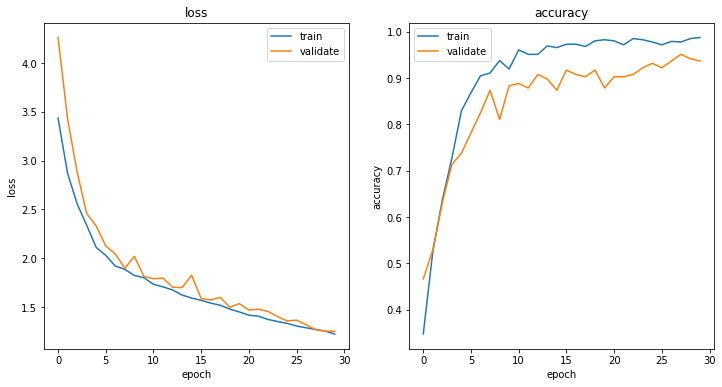

In [30]:
plot_history(history)

In [31]:
score = vgg.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 94.94% 
Test loss     = 1.218494


In [32]:
print(classification_report(y_test.argmax(axis=1), vgg.predict(X_test).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95        56
           1       0.92      0.96      0.94        71
           2       0.97      0.91      0.94        79
           3       0.98      0.98      0.98        51

    accuracy                           0.95       257
   macro avg       0.95      0.95      0.95       257
weighted avg       0.95      0.95      0.95       257



## All the data

In [0]:
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

In [0]:
EPOCHS = 10
LEARNING_RATE = 2e-5

In [0]:
base_model = base_model_hold
base_model.trainable = True
vgg_all = build_network(base_model, dropout_perc=0.5, kernel_reg=0.06)

In [0]:
vgg_all.compile(
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=optimizers.Adam(lr=LEARNING_RATE),
    metrics=['accuracy']
)

In [41]:
history = vgg_all.fit(
    X, y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_split=0.2
)

Train on 1027 samples, validate on 257 samples
Epoch 1/30
1027/1027 [==============================] - 9s 9ms/sample - loss: 3.4101 - accuracy: 0.4664 - val_loss: 3.3975 - val_accuracy: 0.6381
Epoch 2/30
1027/1027 [==============================] - 8s 8ms/sample - loss: 2.5355 - accuracy: 0.7595 - val_loss: 3.1847 - val_accuracy: 0.6965
Epoch 3/30
1027/1027 [==============================] - 8s 8ms/sample - loss: 2.2415 - accuracy: 0.8608 - val_loss: 2.2404 - val_accuracy: 0.8638
Epoch 4/30
1027/1027 [==============================] - 8s 8ms/sample - loss: 2.0752 - accuracy: 0.9133 - val_loss: 2.1001 - val_accuracy: 0.8755
Epoch 5/30
1027/1027 [==============================] - 8s 8ms/sample - loss: 1.9543 - accuracy: 0.9124 - val_loss: 1.8539 - val_accuracy: 0.9572
Epoch 6/30
1027/1027 [==============================] - 8s 8ms/sample - loss: 1.8664 - accuracy: 0.9104 - val_loss: 1.7509 - val_accuracy: 0.9650
Epoch 7/30
1027/1027 [==============================] - 8s 8ms/sample - loss:

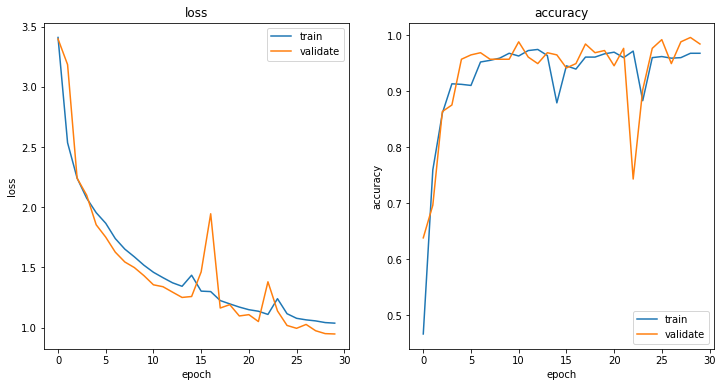

In [42]:
plot_history(history)

# Unseen data

## Helper functions

In [0]:
def store_image(img_url, class_type):

  filename = ''
  response = requests.get(img_url)

  if response.status_code == 200:
    directory = 'car-dataset/train/{}'.format(class_type)
    os.chdir(directory)
    filename = str(max(sorted([int(prefix.split('.')[0]) for prefix in os.listdir()])) + 1)

    with open('{}.jpg'.format(filename), 'wb') as f:
      f.write(response.content)

    os.chdir('../../..')

  return directory + '/{}.jpg'.format(filename)

In [0]:
def classify(img_url, class_type, **trained_model):
  
  filename = store_image(img_url, class_type)
  img = image.load_img(filename, target_size=(224, 224))

  plt.imshow(np.squeeze(img).astype('uint8'))

  img = image.img_to_array(img)
  img = resnet.preprocess_input(img)
  img = np.expand_dims(img, axis=0)

  for name, model in trained_model.items(): 
    golf = model.predict_classes(img)
    if (golf == 0):
      golf = '7.5'
    elif (golf == 1):
      golf = '7'
    elif (golf == 2):#se:
      golf = '6'
    else: 
      golf = 5
    print('Classifier:', name)
    print('Golf model:', golf, ', proba:', model.predict_proba(img), '\n')

## Golf 5

Classifier: vgg_model
Golf model: 5 , proba: [[9.6883141e-02 2.2836172e-04 4.1783151e-01 4.8505703e-01]] 

Classifier: vgg_all
Golf model: 5 , proba: [[0.01518853 0.02114493 0.02656756 0.93709904]] 



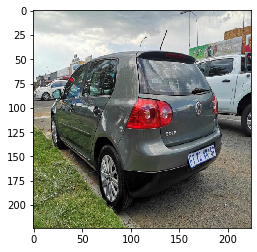

In [90]:
classify(
    'https://www.carmag.co.za/car-images/Gauteng/6091-648349_5/2007-Volkswagen-GOLF-5-GOLF-2.0-COMFORTLINE-5.jpeg',
    '5', vgg_model = vgg, vgg_all = vgg_all
    )

Classifier: vgg_model
Golf model: 6 , proba: [[1.6106939e-02 4.3439705e-04 6.9993234e-01 2.8352627e-01]] 

Classifier: vgg_all
Golf model: 5 , proba: [[0.01333551 0.01679775 0.06971201 0.90015477]] 



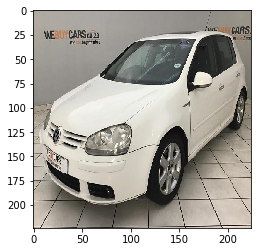

In [91]:
classify(
    'https://img.autotrader.co.za/5332243/Crop800x600',
    '5', vgg_model = vgg, vgg_all = vgg_all
    )

Classifier: vgg_model
Golf model: 7.5 , proba: [[7.7891433e-01 6.2458894e-05 1.0871290e-01 1.1231030e-01]] 

Classifier: vgg_all
Golf model: 5 , proba: [[0.01023024 0.00203749 0.02149118 0.966241  ]] 



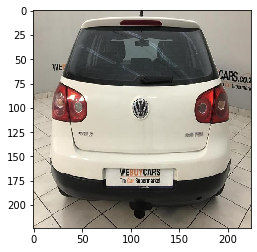

In [92]:
classify(
    'https://img.autotrader.co.za/5332244/Crop800x600',
    '5', vgg_model = vgg, vgg_all = vgg_all
    )

Classifier: vgg_model
Golf model: 6 , proba: [[8.0467336e-02 5.2449923e-05 5.3013104e-01 3.8934916e-01]] 

Classifier: vgg_all
Golf model: 5 , proba: [[3.3894104e-03 4.8746270e-04 3.6948428e-02 9.5917469e-01]] 



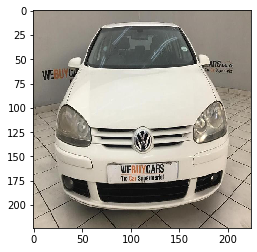

In [93]:
classify(
    'https://img.autotrader.co.za/5332246/Crop800x600',
    '5', vgg_model = vgg, vgg_all = vgg_all
    )

Classifier: vgg_model
Golf model: 6 , proba: [[6.6066004e-04 9.1921022e-05 9.1188657e-01 8.7360859e-02]] 

Classifier: vgg_all
Golf model: 5 , proba: [[0.00620965 0.00366205 0.03864311 0.9514853 ]] 



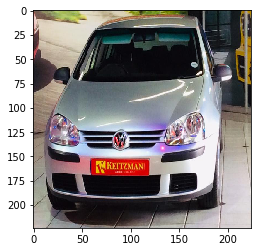

In [94]:
classify(
    'https://img.autotrader.co.za/5243443/Crop800x600',
    '5', vgg_model = vgg, vgg_all = vgg_all
    )

Classifier: vgg_model
Golf model: 6 , proba: [[0.0444992  0.13622828 0.4173985  0.4018741 ]] 

Classifier: vgg_all
Golf model: 5 , proba: [[0.02867505 0.0313739  0.07614837 0.8638027 ]] 



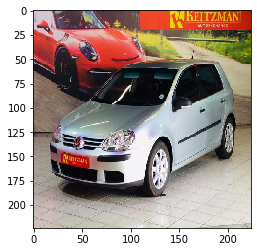

In [95]:
classify(
    'https://img.autotrader.co.za/5243442/Crop800x600',
    '5', vgg_model = vgg, vgg_all = vgg_all
    )

## Golf 6

Classifier: vgg_model
Golf model: 6 , proba: [[1.4092904e-04 1.0388106e-04 9.9963403e-01 1.2113417e-04]] 

Classifier: vgg_all
Golf model: 6 , proba: [[0.00293558 0.00113572 0.9786324  0.01729632]] 



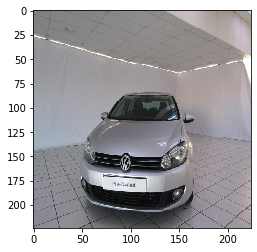

In [97]:
classify(
    'https://img.autotrader.co.za/3760195/Crop800x600',
    '6', vgg_model = vgg, vgg_all = vgg_all
    )

Classifier: vgg_model
Golf model: 6 , proba: [[2.22079878e-04 1.02411286e-04 9.99616027e-01 5.94388257e-05]] 

Classifier: vgg_all
Golf model: 6 , proba: [[0.00779898 0.00259394 0.9635425  0.02606457]] 



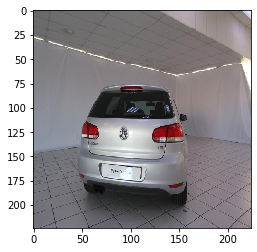

In [98]:
classify(
    'https://img.autotrader.co.za/3760198/Crop800x600',
    '6', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 6 , proba: [[4.3076679e-02 2.3076922e-04 9.5574462e-01 9.4795960e-04]] 

Classifier: vgg_all
Golf model: 6 , proba: [[1.36021115e-02 8.52328667e-04 9.50392723e-01 3.51527520e-02]] 



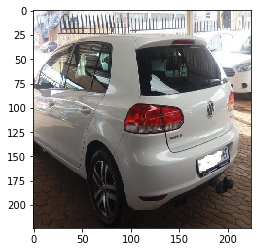

In [53]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5416351_5.jpg?v=1868034972',
    '6', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.00832267 0.00167597 0.9887533  0.00124802]] 



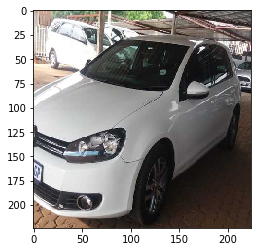

In [54]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5416351.jpg?v=1868034972',
    '6', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 6 , proba: [[2.2407751e-01 3.2457432e-03 7.7243775e-01 2.3901826e-04]] 

Classifier: vgg_all
Golf model: 6 , proba: [[0.01601799 0.00283035 0.93682545 0.04432616]] 



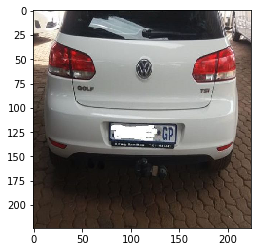

In [55]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5416351_6.jpg?v=1868034972',
    '6', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 6 , proba: [[3.6066407e-04 6.3080667e-04 9.9852592e-01 4.8267341e-04]] 

Classifier: vgg_all
Golf model: 6 , proba: [[0.01066006 0.00999941 0.9490995  0.03024106]] 



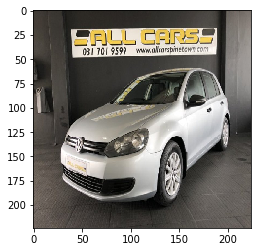

In [56]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_large/5532964.jpg?v=125421204',
    '6', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 6 , proba: [[1.6526600e-04 8.2210550e-05 9.9970263e-01 4.9869352e-05]] 



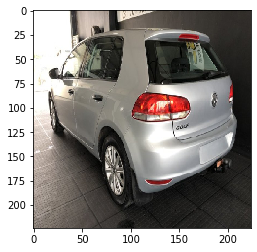

In [57]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_large/5532964_3.jpg?v=125421204',
    '6', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 6 , proba: [[1.1749910e-03 4.7142190e-04 9.9823111e-01 1.2242323e-04]] 

Classifier: vgg_all
Golf model: 6 , proba: [[3.4887441e-03 3.1842722e-04 9.6664554e-01 2.9547265e-02]] 



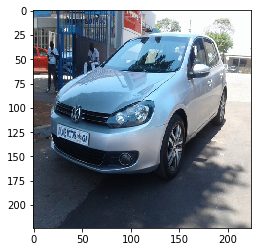

In [100]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518.jpg?v=2265708515',
    '6', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 6 , proba: [[1.9524432e-03 1.0834366e-04 9.9751770e-01 4.2152323e-04]] 

Classifier: vgg_all
Golf model: 6 , proba: [[4.7645890e-03 3.2823312e-04 9.5761776e-01 3.7289456e-02]] 



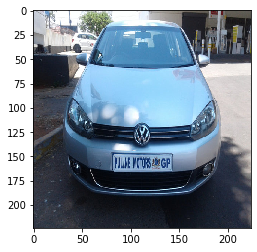

In [59]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_2.jpg?v=2265708515',
    '6', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 6 , proba: [[1.1903296e-04 4.5094537e-05 9.9983191e-01 3.9378338e-06]] 

Classifier: vgg_all
Golf model: 6 , proba: [[2.2704073e-03 8.7060209e-04 9.7716969e-01 1.9689301e-02]] 



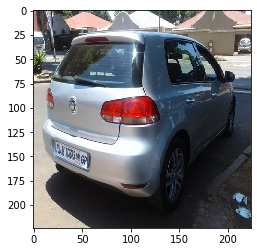

In [99]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_8.jpg?v=2265708515',
    '6', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 6 , proba: [[1.2336613e-03 1.2093202e-04 9.9858272e-01 6.2718434e-05]] 

Classifier: vgg_all
Golf model: 6 , proba: [[0.00720443 0.00182228 0.9586083  0.032365  ]] 



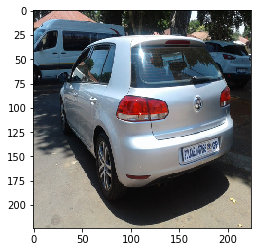

In [61]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_7.jpg?v=2265708515',
    '6', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 6 , proba: [[7.0218695e-05 1.5421932e-04 9.9975032e-01 2.5297781e-05]] 

Classifier: vgg_all
Golf model: 6 , proba: [[0.00580032 0.01080682 0.95315063 0.03024226]] 



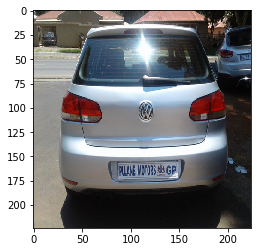

In [62]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_6.jpg?v=2265708515',
    '6', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 6 , proba: [[6.7005027e-04 1.3965840e-04 9.9778533e-01 1.4050062e-03]] 

Classifier: vgg_all
Golf model: 6 , proba: [[0.00704085 0.00701666 0.8184377  0.16750479]] 



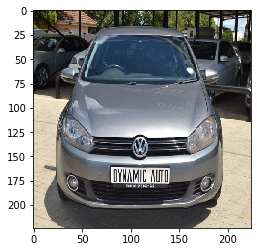

In [63]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5530306_2.jpg?v=4074465811',
    '6', vgg_model = vgg, vgg_all = vgg_all
)

## Golf 7


Classifier: vgg_model
Golf model: 7.5 , proba: [[0.793995   0.02674713 0.17663437 0.00262347]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.05500977 0.8908079  0.01880185 0.0353805 ]] 



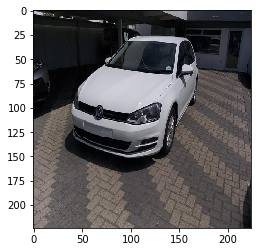

In [64]:
classify(
         'https://img.autotrader.co.za/5248234/Crop800x600',
         '7', vgg_model = vgg, vgg_all = vgg_all
         )


Classifier: vgg_model
Golf model: 7.5 , proba: [[0.90772116 0.00399808 0.08561801 0.00266277]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.04873297 0.8739316  0.03214343 0.04519207]] 



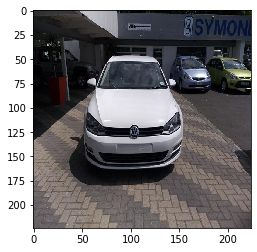

In [65]:
classify(
         'https://img.autotrader.co.za/5248233/Crop800x600',
         '7', vgg_model = vgg, vgg_all = vgg_all
         )

Classifier: vgg_model
Golf model: 7.5 , proba: [[0.6113236  0.14827509 0.23758484 0.00281651]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.00709327 0.9628254  0.01306064 0.0170207 ]] 



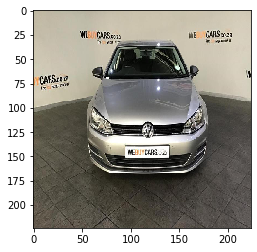

In [66]:
classify(
         'https://img.autotrader.co.za/5369150/Crop800x600',
         '7', vgg_model = vgg, vgg_all = vgg_all
         )

Classifier: vgg_model
Golf model: 7.5 , proba: [[9.1874415e-01 1.4254852e-02 6.6780783e-02 2.2020467e-04]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.00526215 0.9861501  0.00302605 0.00556165]] 



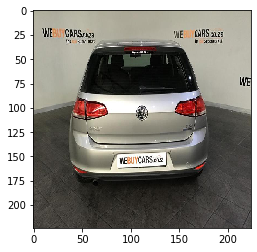

In [67]:
classify(
         'https://img.autotrader.co.za/5369148/Crop800x600',
         '7', vgg_model = vgg, vgg_all = vgg_all
         )

Classifier: vgg_model
Golf model: 6 , proba: [[0.2987161  0.04849466 0.64855903 0.00423016]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.02046937 0.91529995 0.02919633 0.03503438]] 



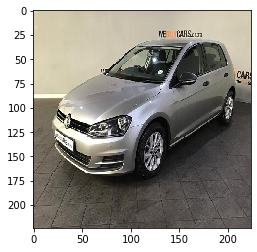

In [68]:
classify(
         'https://img.autotrader.co.za/5369147/Crop800x600',
         '7', vgg_model = vgg, vgg_all = vgg_all
         )

Classifier: vgg_model
Golf model: 7.5 , proba: [[9.2880517e-01 1.0590392e-02 6.0363691e-02 2.4077887e-04]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.0213959  0.9567451  0.01249254 0.00936648]] 



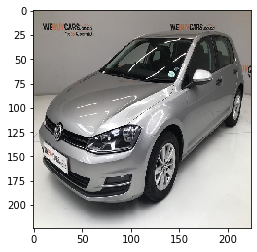

In [69]:
classify(
         'https://img.autotrader.co.za/5369468/Crop800x600',
         '7', vgg_model = vgg, vgg_all = vgg_all
         )

Classifier: vgg_model
Golf model: 7.5 , proba: [[8.9049035e-01 5.1321134e-02 5.7938665e-02 2.4989140e-04]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.00528816 0.98210174 0.0069074  0.00570265]] 



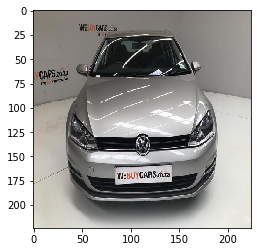

In [70]:
classify(
         'https://img.autotrader.co.za/5369471/Crop800x600',
         '7', vgg_model = vgg, vgg_all = vgg_all
         )

Classifier: vgg_model
Golf model: 7.5 , proba: [[7.3095131e-01 1.9961217e-02 2.4870533e-01 3.8205006e-04]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.02656593 0.91435957 0.04150238 0.01757215]] 



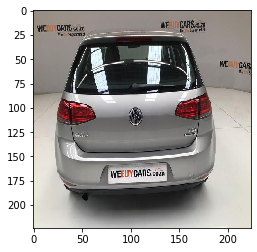

In [71]:
classify(
         'https://img.autotrader.co.za/5369469/Crop800x600',
         '7', vgg_model = vgg, vgg_all = vgg_all
         )

Classifier: vgg_model
Golf model: 6 , proba: [[0.07317962 0.02154869 0.90191096 0.00336075]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.01086091 0.79019016 0.12690811 0.0720408 ]] 



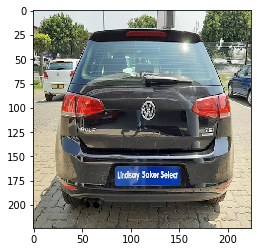

In [72]:
classify(
    'https://img.autotrader.co.za/5353441/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[9.5174509e-01 7.0408685e-03 4.0927019e-02 2.8698906e-04]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.04803117 0.8999205  0.02788451 0.02416372]] 



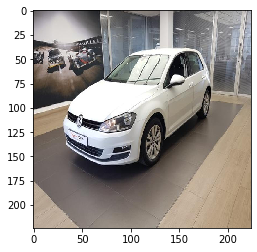

In [73]:
classify(
    'https://img.autotrader.co.za/5375620/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[9.9573636e-01 3.5143215e-03 7.2433404e-04 2.4995436e-05]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.01829553 0.963082   0.00719453 0.01142792]] 



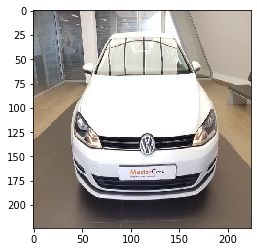

In [74]:
classify(
    'https://img.autotrader.co.za/5375621/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[9.8070258e-01 1.9704604e-03 1.7282674e-02 4.4241086e-05]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.07149421 0.86601365 0.04640822 0.016084  ]] 



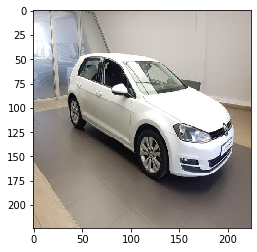

In [75]:
classify(
    'https://img.autotrader.co.za/5375622/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[9.8027337e-01 7.6882495e-03 1.1939355e-02 9.8936085e-05]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.23065533 0.49103627 0.15505427 0.12325408]] 



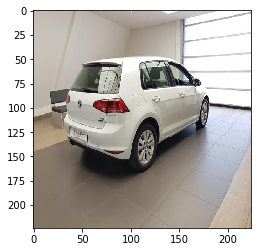

In [76]:
classify(
    'https://img.autotrader.co.za/5375623/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[8.84703755e-01 4.76287911e-03 1.10290505e-01 2.42806636e-04]] 

Classifier: vgg_all
Golf model: 7 , proba: [[0.34605968 0.45296675 0.15036751 0.05060611]] 



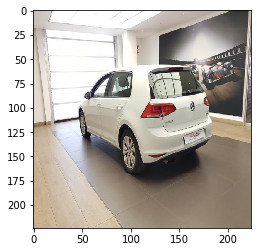

In [77]:
classify(
    'https://img.autotrader.co.za/5375624/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

## Golf 7.5

Classifier: vgg_model
Golf model: 7.5 , proba: [[9.972179e-01 4.941890e-05 2.660970e-03 7.164601e-05]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.63018346 0.2399671  0.07089479 0.05895457]] 



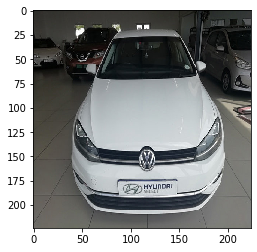

In [78]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5570873_3.jpg?v=317154964',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[9.9977821e-01 7.7662628e-07 2.1661169e-04 4.3504938e-06]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.90598005 0.00828459 0.03446164 0.05127376]] 



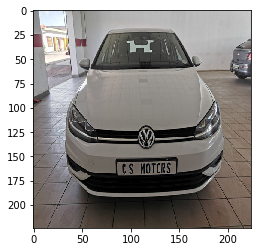

In [79]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5428529_2.jpg?v=158700226',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[9.9993873e-01 1.7446899e-05 4.3193020e-05 6.5858222e-07]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.88819224 0.04866428 0.0220436  0.04109989]] 



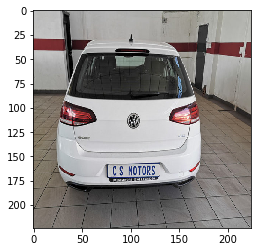

In [80]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5428529_7.jpg?v=158700226',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[9.9932861e-01 5.3299755e-05 6.1143364e-04 6.7616234e-06]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.9459583  0.01066039 0.02864984 0.01473146]] 



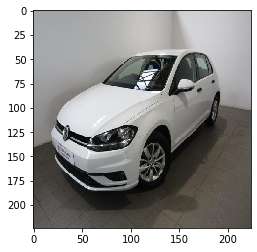

In [81]:
classify(
    'https://img.autotrader.co.za/5361261/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[9.9987495e-01 1.7203764e-06 1.2158273e-04 1.7807058e-06]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.94307065 0.01811158 0.01982216 0.01899558]] 



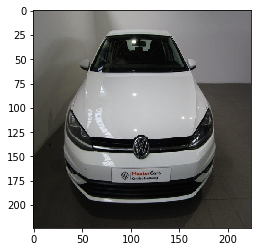

In [82]:
classify(
    'https://img.autotrader.co.za/5361262/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[9.9974889e-01 8.7538374e-06 2.3626201e-04 6.1874116e-06]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.77278596 0.125609   0.03912681 0.06247822]] 



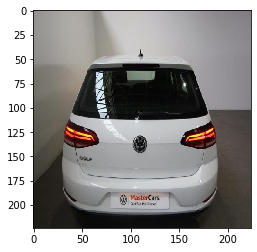

In [83]:
classify(
    'https://img.autotrader.co.za/5361267/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[9.9539548e-01 3.7780082e-05 4.5178733e-03 4.8931262e-05]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.88735867 0.04088557 0.02880674 0.04294898]] 



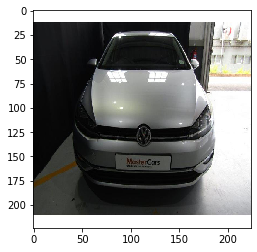

In [84]:
classify(
    'https://img.autotrader.co.za/5149727/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[9.96781945e-01 2.21721693e-05 3.18546710e-03 1.03120965e-05]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.67362255 0.09155416 0.17890397 0.05591937]] 



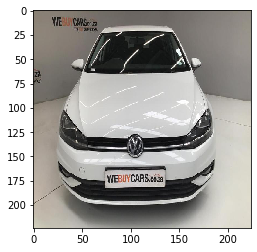

In [85]:
classify(
    'https://img.autotrader.co.za/5314452/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[9.9994302e-01 1.7900508e-06 5.3486037e-05 1.7518089e-06]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.89694554 0.00520686 0.03355186 0.06429571]] 



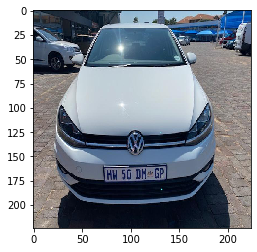

In [86]:
classify(
    'https://img.autotrader.co.za/5375761/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[9.9993622e-01 1.2924600e-05 4.9955317e-05 9.2829663e-07]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.7958934  0.04741599 0.03305102 0.12363962]] 



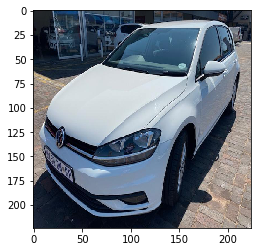

In [87]:
classify(
    'https://img.autotrader.co.za/5375760/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[9.9978215e-01 4.1047879e-05 1.5050702e-04 2.6416203e-05]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.82196456 0.04102588 0.03620207 0.1008075 ]] 



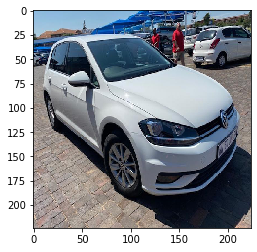

In [88]:
classify(
    'https://img.autotrader.co.za/5375763/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

Classifier: vgg_model
Golf model: 7.5 , proba: [[9.9987054e-01 5.1768038e-06 1.1091331e-04 1.3364856e-05]] 

Classifier: vgg_all
Golf model: 7.5 , proba: [[0.60716546 0.32495108 0.03110152 0.03678189]] 



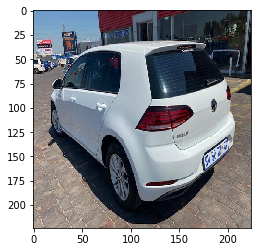

In [89]:
classify(
    'https://img.autotrader.co.za/5375762/Crop800x600',
    '7_5', vgg_model = vgg, vgg_all = vgg_all
)

In [0]:
# 1. Change classify function to accept multiple models
# 2. Build simple network to count side/front/rear shots of each class
# 3. Investigate network ensemblefrom sklearn.metrics import classification_report